# Bird classification using CNN with PyTorch

In [36]:
import os
import csv
import numpy as np
import torch
import torch.utils.data as td
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from datetime import datetime

In [37]:
IN_DIR_DATA = 'data/CUB_200_2011/'
IN_DIR_IMG = os.path.join(IN_DIR_DATA, 'images')
f_list = os.listdir(IN_DIR_IMG)
print(f_list[0])

091.Mockingbird


### Prepare the dataset

CUB-200-2011 dataset contains thousands of images, so it is convenient to first create class **DatasetBirds** to handle data loading and pre-processing

In [38]:
class DatasetBirds(tv.datasets.ImageFolder):
    """
    Wrapper for the CUB-200-2011 dataset. 
    Method DatasetBirds.__getitem__() returns tuple of image and its corresponding label.    
    """
    def __init__(self,
                 root,
                 transform=None,
                 target_transform=None,
                 loader=tv.datasets.folder.default_loader,
                 is_valid_file=None,
                 train=True):
        
        img_root = os.path.join(root, 'images')
        
        super(DatasetBirds, self).__init__(
            root=img_root,
            transform=None,
            target_transform=None,
            loader=loader,
            is_valid_file=is_valid_file,
        )
        self.transform_ = transform
        self.target_transform_ = target_transform
        self.train = train
        
        # obtain sample ids filtered by split
        path_to_splits = os.path.join(root, 'train_test_split.txt')
        indices_to_use = list()
        with open(path_to_splits, 'r') as in_file:
            for line in in_file:
                idx, use_train = line.strip('\n').split(' ', 2)
                if bool(int(use_train)) == self.train:
                    indices_to_use.append(int(idx))
                    
        # obtain filenames of images
        path_to_index = os.path.join(root, 'images.txt')
        filenames_to_use = set()
        with open(path_to_index, 'r') as in_file:
            for line in in_file:
                idx, fn = line.strip('\n').split(' ', 2)
                if int(idx) in indices_to_use:
                    filenames_to_use.add(fn)
                    
        img_paths_cut = {'/'.join(img_path.rsplit('/', 2)[-2:]): idx for idx, (img_path, lb) in enumerate(self.imgs)}
        imgs_to_use = [self.imgs[img_paths_cut[fn]] for fn in filenames_to_use]
        
        _, targets_to_use = list(zip(*imgs_to_use))
        
        self.imgs = self.samples = imgs_to_use
        self.targets = targets_to_use
        
    def __getitem__(self, index):
        # generate one sample
        sample, target = super(DatasetBirds, self).__getitem__(index)
                    
        if self.transform_ is not None:
            sample = self.transform_(sample)
            
        if self.target_transform_ is not None:
            target = self.target_transform_(target)
                
        return sample, target

In [39]:
# Helper functions
def pad(img, size_max=500):
    """
    Pads images to the specified size (height x width). 
    """
    pad_height = max(0, size_max - img.height)
    pad_width = max(0, size_max - img.width)
    
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    return TF.pad(
        img,
        (pad_left, pad_top, pad_right, pad_bottom),
        fill=tuple(map(lambda x: int(round(x * 256)), (0.485, 0.456, 0.406))))

def read_class_names(filename):
    classNames = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        for line in lines:
            line = line.split()[-1] # Take the last part after space
            line = line.split('.')[-1] # Take the part after '.'
            classNames.append(line) #add to list
     
    # close file
    file.close()
    
    return classNames

### Prepare the DataLoaders: Preprocessing transforms

In [40]:
# transform images
transforms_train = tv.transforms.Compose([
   tv.transforms.Lambda(pad),
   tv.transforms.Resize((232,232)),
   tv.transforms.RandomOrder([
       tv.transforms.CenterCrop((224, 224)),
   ]),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_eval = tv.transforms.Compose([
   tv.transforms.Lambda(pad),
   tv.transforms.Resize((232,232)),
   tv.transforms.CenterCrop((224, 224)),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Instantiate Dataset and DataLoaders

In [41]:
## --- Set hyper-parameters --- ##
batch_size = 64 # Choose a number 
num_classes = 200 # How many classes in the dataset?
## ---------------------------- ##

# Set
batch_size_train = batch_size
batch_size_test = batch_size
params = {'batch_size': batch_size_train, 'num_workers': 8}

# Instantiate
ds_train = DatasetBirds(IN_DIR_DATA, transform=transforms_train, train=True)
ds_test = DatasetBirds(IN_DIR_DATA, transform=transforms_eval, train=False)
n_train = len(ds_train)
n_test = len(ds_test)

# Check the number of images in the split
print('Size of training set: ' + str(n_train))
print('Size of test set: ' + str(n_test))
print('Total number of images: ' + str(len(ds_train) + len(ds_test)))

Size of training set: 5994
Size of test set: 5794
Total number of images: 11788


In [42]:
# Instantiate the data loaders
train_loader = td.DataLoader(dataset=ds_train, **params, shuffle=True)
test_loader = td.DataLoader(dataset=ds_test, **params, shuffle=False)

### Sanity checking the DataLoader

When DataSets are non-standard benchmark datasets, it is obviously always a good idea to check what comes out of the DataLoaders.
- Does data and label have the expected shape/size?
- Does the Train and Test Loader give the same type of output?
- Does the Transforms behave as expected?

Training loader:
--Input batch shape: torch.Size([64, 3, 224, 224])
--Image size: (224, 224, 3)
--Min value: -2.0836544
--Max value: 2.5702832
--Label batch shape: torch.Size([64])
--Label: 2
Test loader:
--Input batch shape: torch.Size([64, 3, 224, 224])
--Image size: (224, 224, 3)
--Min value: -2.0836544
--Max value: 2.535425
--Label batch shape: torch.Size([64])
--Label: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image from test loader\nLabel: 2\nClass: Sooty_Albatross')

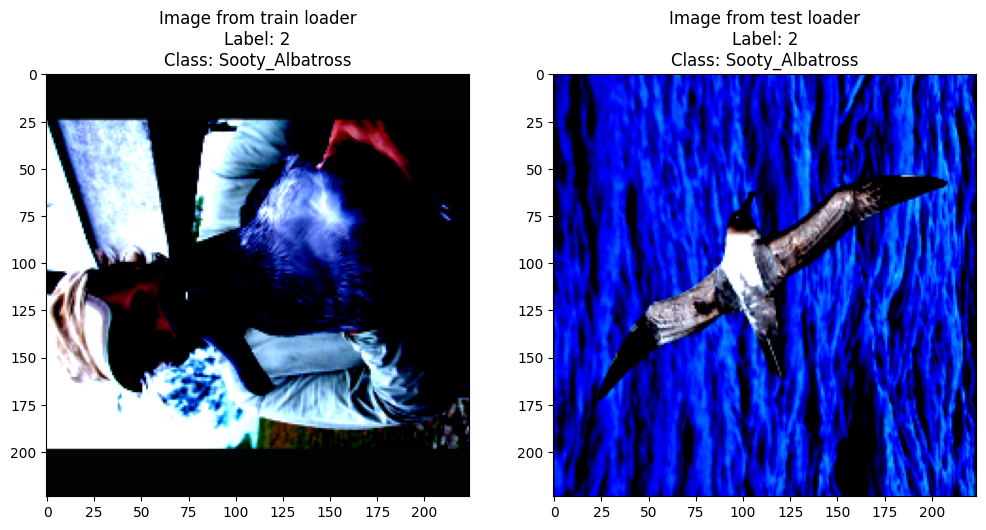

In [43]:
# Pick one label/class to for checking 
checkLabel = 2
# Read the class names <-> label mapping
classnameList = read_class_names(IN_DIR_DATA + 'classes.txt')

# Check the train and test loader
for b, batch in enumerate(train_loader):
    x, y = batch

    idx = y.numpy() == checkLabel
    if np.any(idx):
        i = np.where(idx)[0][0]
        train_img = x[i,:,:,:].numpy()
        train_img = np.transpose(train_img, (2, 1, 0))
        train_lbl = y[i].numpy()

        print('Training loader:')
        print('--Input batch shape: ' + str(x.shape))
        print('--Image size: ' + str(train_img.shape))
        print('--Min value: ' + str(np.min(train_img)))
        print('--Max value: ' + str(np.max(train_img)))
        print('--Label batch shape: ' + str(y.shape))
        print('--Label: ' + str(train_lbl))
        break
for b, batch in enumerate(test_loader):
    x, y = batch

    idx = y.numpy() == checkLabel
    if np.any(idx):
        i = np.where(idx)[0][0]
        test_img = x[i,:,:,:].numpy()
        test_img = np.transpose(test_img, (2, 1, 0))
        test_lbl = y[i].numpy()

        print('Test loader:')
        print('--Input batch shape: ' + str(x.shape))
        print('--Image size: ' + str(test_img.shape))
        print('--Min value: ' + str(np.min(test_img)))
        print('--Max value: ' + str(np.max(test_img)))
        print('--Label batch shape: ' + str(y.shape))
        print('--Label: ' + str(test_lbl))
        break
# Showcase
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].imshow(train_img)
ax[0].set_title('Image from train loader\nLabel: ' + str(train_lbl) + '\nClass: ' + classnameList[train_lbl])

ax[1].imshow(test_img)
ax[1].set_title('Image from test loader\nLabel: ' + str(test_lbl) + '\nClass: ' + classnameList[test_lbl])


### Set-up the CNN model

In [44]:
class Net(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64*14*14, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [45]:
# Instantiate the model
num_channels = 3 #[R,G,B]
model = Net(num_channels=num_channels, num_classes=num_classes)
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(

### Specify the loss function and optimizer

In [46]:
# Loss function and optimizer
learning_rate = 3e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1734424

### Set-up the training stage

**NB:** The training loop can be directly copied from the MNIST classification from week 1, with the following changes.
- When applying the model we should no longer flatten the input image (i.e. remove "*.view(batch_size_train,-1))*")
- The printing of the interim training process should just be moved outside of the batch loop. No need to check when the loop is at the end. Secondly, the size of the train and test set was hardcoded for the accuracy calculation - that was a bit sloppy of me.

In [48]:
from tqdm import tqdm

# Epochs
epochs = 40 # Epoch is one pass of all training data

# Preparation:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [49]:
timestamp_start = datetime.now()
current_time = timestamp_start.strftime("%H:%M:%S")
print('Network training start time = ', current_time)

# Train the network
train_losses = []
train_correct = []
test_losses = []
test_correct = []
all_true_labels = []
all_predictions = []
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run training batches
    for b, (x_train, y_train) in enumerate(tqdm(train_loader)):
        b+=1

        #Apply model
        y_pred = model(x_train.to(device))
        loss = criterion(y_pred, y_train.to(device))

        # Calculate number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.to(device)).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad() #reset gradients after each training step
        loss.backward() #trigger backpropagation
        optimizer.step()

    # Print interim results
    print(f'epoch: {i:2} , Train loss: {loss.item():10.8f} , Train accuracy: {trn_corr.item()*100/len(train_loader):4.2f}')

    # Update train loss and accuracy for the epoch
    train_losses.append(loss.item())
    train_correct.append(trn_corr.cpu())

    # Run testing batches
    with torch.no_grad():
        for b, (x_test, y_test) in enumerate(tqdm(test_loader)):

            # Apply model
            y_val = model(x_test.to(device))
    
            # Tally Correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test.to(device)).sum()
            all_true_labels.extend(y_test.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Update test loss and accuracy for the epoch
    loss = criterion(y_val, y_test.to(device))
    test_losses.append(loss.cpu())
    test_correct.append(tst_corr.cpu())
    
# Print final accuracy
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_loader):.3f}%')

timestamp_end = datetime.now()
current_time = timestamp_end.strftime("%H:%M:%S")
print('Network training end time = ', current_time)

Network training start time =  15:07:42


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.41it/s]


epoch:  0 , Train loss: 5.29347610 , Train accuracy: 46.81


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.25it/s]


epoch:  1 , Train loss: 5.10302162 , Train accuracy: 84.04


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.85it/s]


epoch:  2 , Train loss: 4.74110365 , Train accuracy: 146.81


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.64it/s]


epoch:  3 , Train loss: 4.33703804 , Train accuracy: 330.85


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.15it/s]


epoch:  4 , Train loss: 4.51400375 , Train accuracy: 491.49


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.16it/s]


epoch:  5 , Train loss: 4.10724545 , Train accuracy: 684.04


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.18it/s]


epoch:  6 , Train loss: 3.58389854 , Train accuracy: 918.09


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.79it/s]


epoch:  7 , Train loss: 3.59930086 , Train accuracy: 1100.00


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.21it/s]


epoch:  8 , Train loss: 3.27080059 , Train accuracy: 1302.13


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.19it/s]


epoch:  9 , Train loss: 3.58082533 , Train accuracy: 1539.36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.60it/s]


epoch: 10 , Train loss: 2.98632765 , Train accuracy: 1830.85


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.02it/s]


epoch: 11 , Train loss: 2.84280467 , Train accuracy: 2068.09


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.75it/s]


epoch: 12 , Train loss: 2.79727530 , Train accuracy: 2375.53


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.19it/s]


epoch: 13 , Train loss: 2.22242594 , Train accuracy: 2597.87


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.07it/s]


epoch: 14 , Train loss: 1.93072510 , Train accuracy: 2890.43


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.90it/s]


epoch: 15 , Train loss: 2.11428142 , Train accuracy: 3246.81


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.19it/s]


epoch: 16 , Train loss: 1.64982963 , Train accuracy: 3504.26


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.02it/s]


epoch: 17 , Train loss: 1.37503612 , Train accuracy: 3781.91


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.65it/s]


epoch: 18 , Train loss: 1.47790992 , Train accuracy: 4081.91


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.11it/s]


epoch: 19 , Train loss: 1.14208198 , Train accuracy: 4367.02


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.98it/s]


epoch: 20 , Train loss: 1.09913540 , Train accuracy: 4690.43


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.41it/s]


epoch: 21 , Train loss: 1.04453492 , Train accuracy: 4874.47


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.80it/s]


epoch: 22 , Train loss: 0.95030892 , Train accuracy: 5187.23


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.67it/s]


epoch: 23 , Train loss: 0.57010216 , Train accuracy: 5462.77


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.54it/s]


epoch: 24 , Train loss: 0.59765881 , Train accuracy: 5641.49


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.78it/s]


epoch: 25 , Train loss: 0.52671182 , Train accuracy: 5759.57


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.02it/s]


epoch: 26 , Train loss: 0.59855300 , Train accuracy: 5932.98


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.11it/s]


epoch: 27 , Train loss: 0.36553803 , Train accuracy: 6084.04


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.64it/s]


epoch: 28 , Train loss: 0.20935315 , Train accuracy: 6141.49


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.01it/s]


epoch: 29 , Train loss: 0.32434464 , Train accuracy: 6220.21


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.73it/s]


epoch: 30 , Train loss: 0.20616405 , Train accuracy: 6262.77


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.07it/s]


epoch: 31 , Train loss: 0.16073163 , Train accuracy: 6305.32


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.70it/s]


epoch: 32 , Train loss: 0.10382164 , Train accuracy: 6327.66


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.92it/s]


epoch: 33 , Train loss: 0.13115412 , Train accuracy: 6365.96


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.14it/s]


epoch: 34 , Train loss: 0.11945949 , Train accuracy: 6367.02


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.70it/s]


epoch: 35 , Train loss: 0.07100936 , Train accuracy: 6374.47


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.86it/s]


epoch: 36 , Train loss: 0.03803017 , Train accuracy: 6374.47


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.10it/s]


epoch: 37 , Train loss: 0.07172512 , Train accuracy: 6376.60


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 18.04it/s]


epoch: 38 , Train loss: 0.04673785 , Train accuracy: 6374.47


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:05<00:00, 17.85it/s]


epoch: 39 , Train loss: 0.02569194 , Train accuracy: 6376.60


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:04<00:00, 20.62it/s]

Test accuracy: 772.527%
Network training end time =  15:14:12


In [50]:
from sklearn.metrics import classification_report
report = classification_report(all_true_labels, all_predictions, target_names=classnameList)
print(report)

                                precision    recall  f1-score   support

        Black_footed_Albatross       0.11      0.10      0.11      1200
              Laysan_Albatross       0.11      0.10      0.10      1200
               Sooty_Albatross       0.06      0.04      0.05      1120
             Groove_billed_Ani       0.12      0.16      0.14      1200
                Crested_Auklet       0.15      0.19      0.17       560
                  Least_Auklet       0.03      0.06      0.04       440
               Parakeet_Auklet       0.10      0.12      0.11       920
             Rhinoceros_Auklet       0.14      0.18      0.16       720
              Brewer_Blackbird       0.06      0.04      0.05      1160
          Red_winged_Blackbird       0.35      0.34      0.35      1200
               Rusty_Blackbird       0.03      0.04      0.03      1200
       Yellow_headed_Blackbird       0.37      0.41      0.39      1040
                      Bobolink       0.13      0.13      0.13  

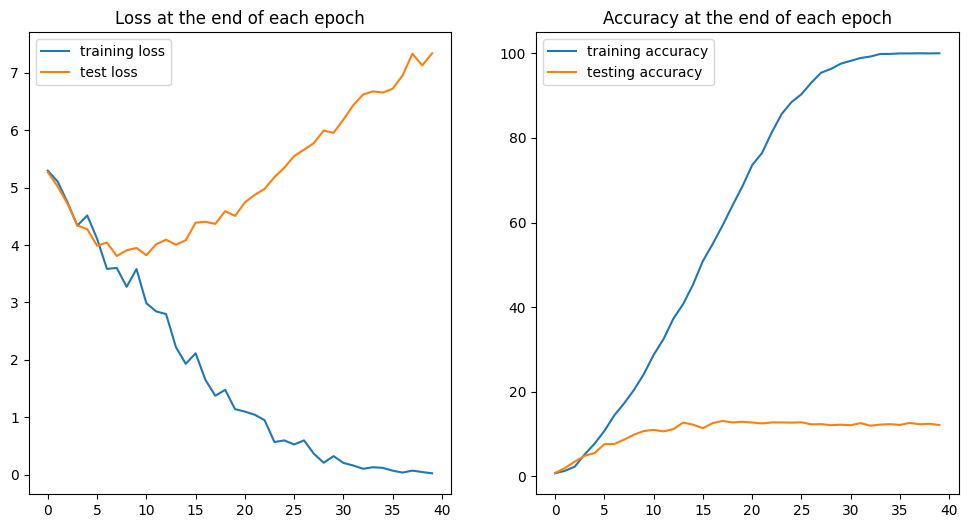

In [51]:
# Plot progression
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(train_losses, label='training loss')
ax[0].plot(test_losses, label='test loss')
ax[0].set_title('Loss at the end of each epoch')
ax[0].legend()

ax[1].plot([t*100/n_train for t in train_correct], label='training accuracy')
ax[1].plot([t*100/n_test for t in test_correct], label='testing accuracy')
ax[1].set_title('Accuracy at the end of each epoch')
ax[1].legend()

### Error exploration
Find misclassifications for a particular class 

In [55]:
# Initialize arrays for incorrect predictions
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []

## --- Choose class label to explore --- ##
checkLabel = 203 #Here focus on this specific class label [0, num_classes]
# -------------------------------------- ##

# Initialize
count_misclass = 0
count_correct = 0
model.eval()
for b, (data, target) in enumerate(test_loader):

    # If batch contains the checkLabel -> predict the batch
    if np.any(target.numpy() == checkLabel):
        
        idx = np.where(target.numpy() == checkLabel) # Which entry of batch is checkLabel?

        # Predict
        data , target = data.to(device), target.to(device)
        output = model(data) # shape = torch.Size([batch_size, num_classes])
        pred = output.argmax(dim=1, keepdim=True) #pred will be a 2d tensor of shape [batch_size,1]

        # Check if classification is correct
        for i in np.nditer(idx):
            # Add misclassifications to list
            if not pred[i].cpu().numpy() == checkLabel:
                count_misclass += 1
                incorrect_examples.append(data[i].squeeze().cpu().numpy())
                incorrect_labels.append(target[i].cpu().numpy()) #the corresponding target to the misclassified image
                incorrect_pred.append(pred[i].squeeze().cpu().numpy()) #the corresponiding predicted class of the misclassified image
            else:
                count_correct += 1
print('Misclassifications of class ' + str(checkLabel) + ': ' + str(count_misclass))

Misclassifications of class 203: 0


In [56]:
count_correct

0

In [57]:
# Showcase misclassified examples

## --- Pick ID to show --- ##
idNo = 3
## ----------------------- ##

# Get image and labels
image = incorrect_examples[idNo]
label_true = incorrect_labels[idNo]
label_pred = incorrect_pred[idNo]
class_true = classnameList[label_true]
class_pred = classnameList[label_pred]

# Display
image = np.transpose(image, (2, 1, 0))

# Showcase
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title('Misclassification example\nLabel: ' + str(label_true) + ' / ' + str(label_pred) + '\nClass: ' + classnameList[label_true] + ' / ' + classnameList[label_pred])

IndexError: list index out of range

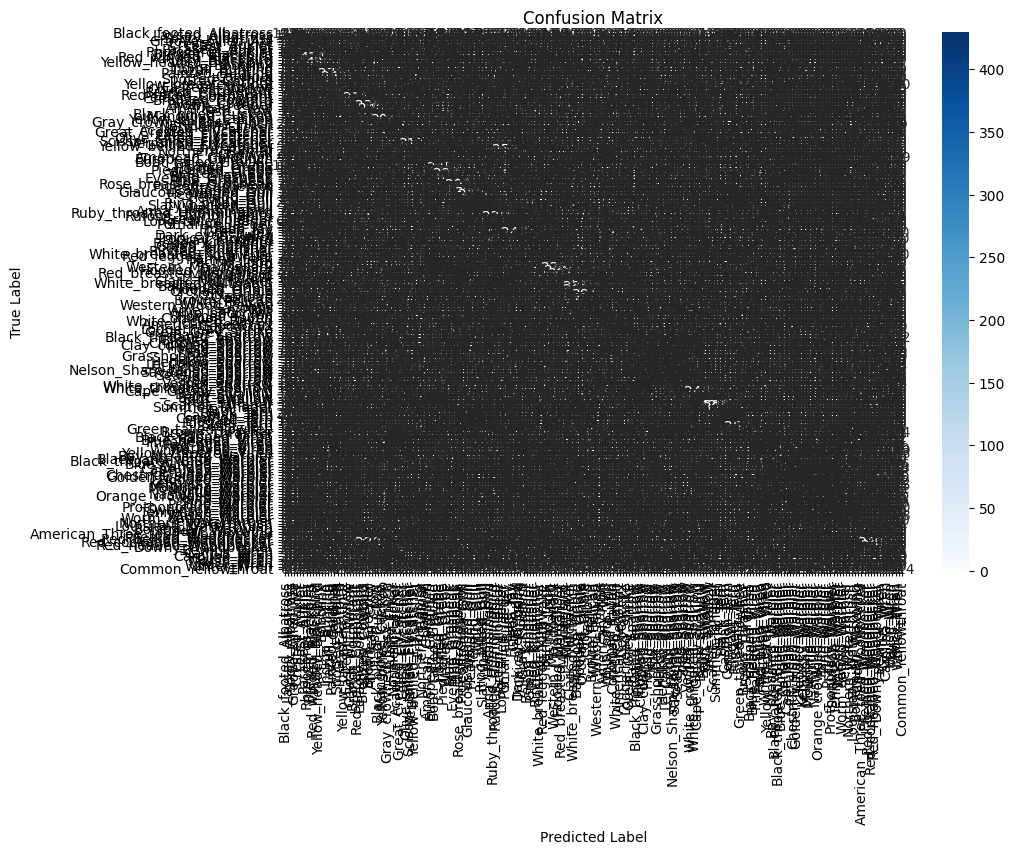

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `all_true_labels` and `all_predictions` are the lists of true labels and predictions
# collected from the test dataset after the testing loop.

conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Now, you can visualize the confusion matrix using Seaborn's heatmap for better readability.
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classnameList, yticklabels=classnameList)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
